In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    PrecisionRecallDisplay,
    precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
np.random.seed(42)

# Подготовка данных

In [3]:
binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", "glasses", "anime", "study_form", "literature"]
N = 11
target_col = binary_cols[N % 8]
target_col

'bad_sleep'

In [4]:
df = pd.read_csv("../../datasets/famcs_students.csv")

to_take = list(df.columns)
to_drop = ["ai"]
cols = [c for c in to_take if c not in to_drop]
fcols = [c for c in cols if c != target_col]
cat_cols = [c for c in fcols if df.dtypes[c] == np.object_]
num_cols = [c for c in fcols if c not in cat_cols]

train, temp = train_test_split(df[cols], train_size=0.7, random_state=42)
test, val = train_test_split(temp, train_size=0.5, random_state=42)

onehot = OneHotEncoder(drop="first", sparse_output=False).fit(train[cat_cols])
scaler = StandardScaler().fit(train[num_cols])

def proc(d):
    vals = onehot.transform(d[cat_cols])
    X = d.drop(columns=cat_cols)
    X[onehot.get_feature_names_out()] = vals
    X[num_cols] = scaler.transform(X[num_cols])
    y = X[target_col].map(lambda x: 0 if x == "Нет" else 1)
    X = X.drop(columns=[target_col])
    return X, y

X_train, y_train = proc(train)
X_test, y_test = proc(test)
X_val, y_val = proc(val)

# Классификаторы

In [5]:
class BaseClassifier:
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        pass

In [6]:
def evaluate(clf: BaseClassifier):
    pred = clf.predict(X_val)
    proba = clf.predict_proba(X_val)

    d = {
        "accuracy": accuracy_score(y_val, pred),
        "precision": precision_score(y_val, pred),
        "recall": recall_score(y_val, pred),
        "roc-auc": roc_auc_score(y_val, proba[:, 1]),
    }

    for k, v in d.items():
        print(f"{k} = {v:.4f}")

    mt = confusion_matrix(y_val, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=mt)
    disp.plot()
    plt.show()

## Трививальный

In [7]:
class TrivialClassifier(BaseClassifier):
    def __init__(self):
        super().__init__()

    def fit(self, X, y):
        v, c = np.unique(y, return_counts=True)
        mf = v[np.argmax(c)]
        self.mf = mf
        return self

    def predict_proba(self, X):
        t = np.zeros([X.shape[0], 2])
        t[:, self.mf] = 1.0
        return t

accuracy = 0.7500
precision = 0.7500
recall = 1.0000
roc-auc = 0.5000


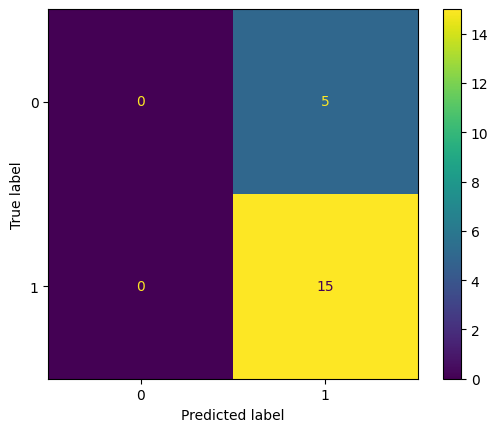

In [8]:
evaluate(TrivialClassifier().fit(X_train, y_train))

## Наивный байесовский

In [9]:
class NaiveBayesClassifier(BaseClassifier):
    def __init__(self):
        super().__init__()
        self.classes_ = None
        self.class_priors_ = None
        self.is_categorical_ = None
        self.cat_probs_ = None
        self.gauss_mean_ = None
        self.gauss_var_ = None

    def _is_binary(self, col):
        unique_vals = np.unique(col)
        return set(unique_vals).issubset({0.0, 1.0})

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y)

        self.classes_, class_counts = np.unique(y, return_counts=True)
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)

        self.class_priors_ = class_counts / n_samples

        self.is_categorical_ = np.array([self._is_binary(X[:, j]) for j in range(n_features)])

        cat_indices = np.where(self.is_categorical_)[0]
        cont_indices = np.where(~self.is_categorical_)[0]

        n_cat = len(cat_indices)
        n_cont = len(cont_indices)

        if n_cat > 0:
            self.cat_probs_ = np.zeros((n_classes, n_cat))
            for c_idx, c in enumerate(self.classes_):
                X_c = X[y == c]
                for j_idx, j in enumerate(cat_indices):
                    count_1 = np.sum(X_c[:, j] == 1.0)
                    n_c = X_c.shape[0]
                    self.cat_probs_[c_idx, j_idx] = (count_1 + 1) / (n_c + 2)
        else:
            self.cat_probs_ = None

        if n_cont > 0:
            self.gauss_mean_ = np.zeros((n_classes, n_cont))
            self.gauss_var_ = np.zeros((n_classes, n_cont))
            for c_idx, c in enumerate(self.classes_):
                X_c = X[y == c][:, cont_indices]
                self.gauss_mean_[c_idx] = np.mean(X_c, axis=0)
                self.gauss_var_[c_idx] = np.var(X_c, axis=0) + 1e-9
        else:
            self.gauss_mean_ = None
            self.gauss_var_ = None

        self.cat_indices_ = cat_indices
        self.cont_indices_ = cont_indices
        return self

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)

        log_proba = np.full((n_samples, n_classes), np.log(self.class_priors_))

        if len(self.cat_indices_) > 0:
            X_cat = X[:, self.cat_indices_]
            prob_1 = self.cat_probs_
            prob_0 = 1.0 - prob_1

            log_prob_cat = np.where(
                X_cat[:, np.newaxis, :] == 1,
                np.log(prob_1),
                np.log(prob_0)
            )

            log_proba += np.sum(log_prob_cat, axis=2)

        if len(self.cont_indices_) > 0:
            X_cont = X[:, self.cont_indices_]
            diff = X_cont[:, np.newaxis, :] - self.gauss_mean_
            var = self.gauss_var_

            log_gauss = -0.5 * (np.log(2 * np.pi * var) + (diff ** 2) / var)
            log_proba += np.sum(log_gauss, axis=2)

        log_proba -= np.max(log_proba, axis=1, keepdims=True)
        proba = np.exp(log_proba)
        proba /= proba.sum(axis=1, keepdims=True)

        return proba

accuracy = 0.3500
precision = 1.0000
recall = 0.1333
roc-auc = 0.6933


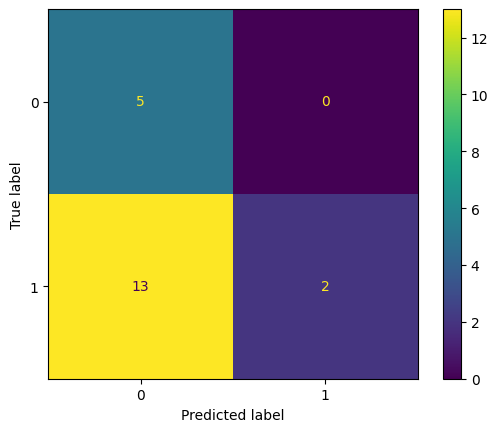

In [10]:
evaluate(NaiveBayesClassifier().fit(X_train, y_train))

## KNN

In [11]:
class KNNClassifier(BaseClassifier):
    def __init__(self, k=5):
        super().__init__()
        self.k = k

    def fit(self, X, y):
        self.X_train_ = np.array(X, dtype=np.float64)
        self.y_train_ = np.array(y)
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        
        proba = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            distances = np.linalg.norm(self.X_train_ - X[i], axis=1)

            k = min(self.k, len(self.y_train_))
            nearest_indices = np.argpartition(distances, k - 1)[:k]
            nearest_labels = self.y_train_[nearest_indices]

            for j, c in enumerate(self.classes_):
                proba[i, j] = np.mean(nearest_labels == c)

        return proba

In [12]:
def fit_knn():
    f = []
    ks = [1, 2, 3, 4, 5, 10, 20]
    for k in ks:
        c = KNNClassifier(k=k).fit(X_train, y_train)
        f.append(f1_score(y_test, c.predict(X_test)))
    k = ks[np.argmax(np.array(f))]
    print(k, f[k])
    return KNNClassifier(k=k).fit(X_train, y_train)

5 0.7857142857142857
accuracy = 0.6500
precision = 0.7222
recall = 0.8667
roc-auc = 0.2467


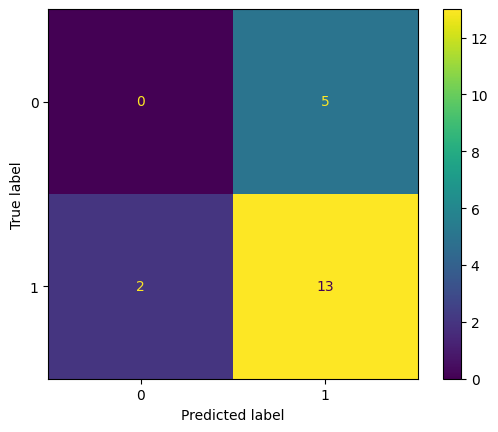

In [13]:
evaluate(fit_knn())

## Логрег

In [14]:
class LogisticRegression(BaseClassifier):
    def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-6):
        super().__init__()
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self._thres = 0.5

    def _set_thres(self, thres):
        self._thres = thres
    
    def _add_intercept(self, X):
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        X = self._add_intercept(X)
        n_samples, n_features = X.shape

        self.coef_ = np.random.normal(scale=0.01, size=n_features)

        prev_loss = float('inf')
        for i in range(self.max_iter):
            z = X @ self.coef_
            y_pred = self._sigmoid(z)

            loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

            errors = y_pred - y
            grad = (X.T @ errors) / n_samples

            self.coef_ -= self.learning_rate * grad

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

        return self

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        X = self._add_intercept(X)
        z = X @ self.coef_
        proba_class_1 = self._sigmoid(z)
        proba = np.vstack([1 - proba_class_1, proba_class_1]).T
        return proba
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas[:, 1] > self._thres).astype(int)

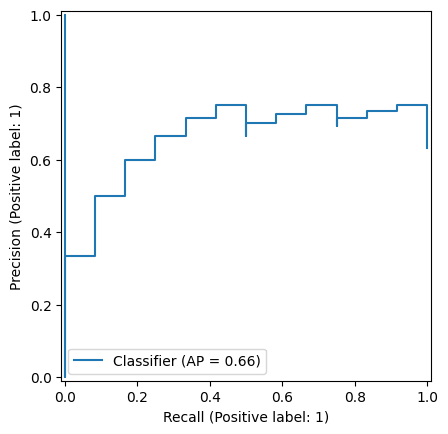

In [15]:
clf = LogisticRegression().fit(X_train, y_train)

display = PrecisionRecallDisplay.from_predictions(
    y_test, clf.predict_proba(X_test)[:, 1]
)
plt.show()

In [16]:
def set_best(clf):
    p, r, t = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    f1 = 2 * (p * r) / (p + r)
    f1 = np.nan_to_num(f1)
    idx = np.argmax(f1)
    best = t[idx]
    plt.plot(t, p[:-1], label="precision")
    plt.plot(t, r[:-1], label="recall")
    plt.legend()
    plt.show()
    print(best, f1[idx])
    clf._set_thres(best)

/tmp/ipykernel_2408/3417339654.py:3: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (p * r) / (p + r)


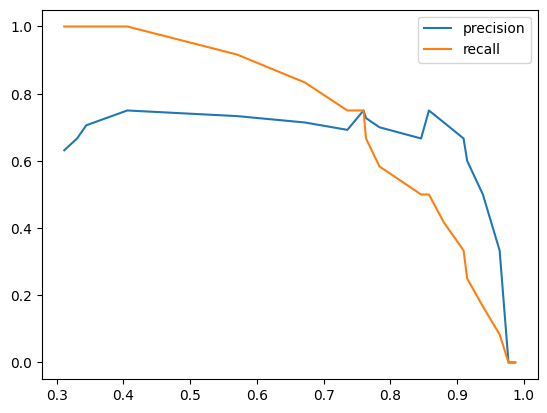

0.40590913479090523 0.8571428571428571


In [17]:
set_best(clf)

accuracy = 0.7500
precision = 0.7778
recall = 0.9333
roc-auc = 0.5867


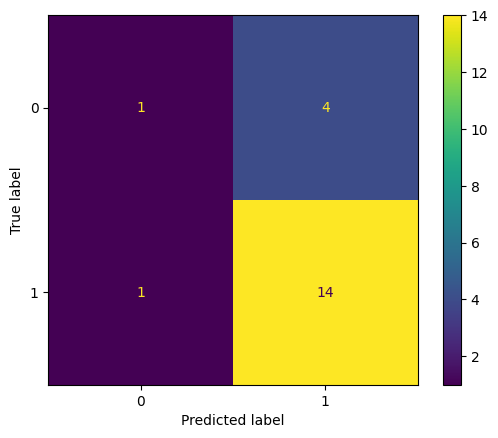

In [18]:
evaluate(clf)

accuracy = 0.5500
precision = 0.8000
recall = 0.5333
roc-auc = 0.5867


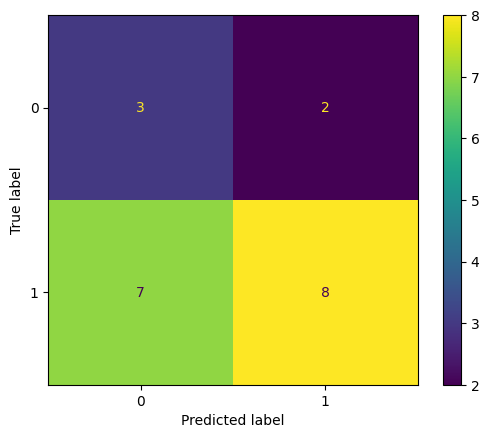

In [20]:
clf._set_thres(0.9)
evaluate(clf)

accuracy = 0.4500
precision = 0.7500
recall = 0.4000
roc-auc = 0.5867


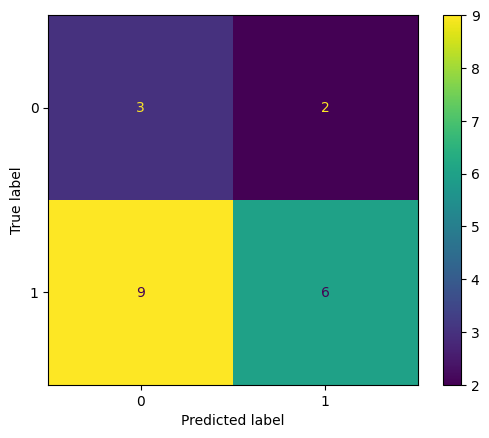

In [21]:
clf._set_thres(0.95)
evaluate(clf)